MSDS 422 Assignment # 2 for James Benco

This section imports and sets up important variables, as well as validates the training and testing data.

In [113]:
from IPython.display import HTML
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [114]:
!pip install --upgrade category_encoders

In [115]:
import os
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import OneHotEncoder
import category_encoders
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import classification_report
from sklearn import dummy

We will first import the data from the Titanic Dataset

In [116]:
#Train Data file
titanTrainDat = pd.read_csv("train.csv")
TrainDat = titanTrainDat.copy()

In [117]:
#Test Data File
titanTestDat = pd.read_csv("test.csv")
TestDat = titanTestDat.copy()

In [118]:
#Sample Submission File
titanSubFile = pd.read_csv("gender_submission.csv")

In [119]:
#Seeing what our data looks like
TrainDat.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [120]:
#Checking all the headers and datatypes of the training data
TrainDat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


From this we can see that there were 891 passengers with 10 features we can use to calibrate our prediction model for survival.
It is also noted that some features have missing data such as "Age" with 177 missing values, "Cabin" with 687 missing values and "Embarked" with 2 missing values.  From this we can see that the "Cabin" features is relatively useless as there are many missing values, this category will be dropped from the model.

In [121]:
#We will now check for normalization, if any exists in the dataset
TrainDat.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


From this the data is not normalized, and that "Age, Fare and SibSp" contain a large range of values with possible outliers.  We will want to clean this up before creating our model.

Statistical EDA

For this model OneHotEncoder will be pivotal in this and in order to limit the amount of unique values while still retaining information, I will transform the "Name" into a categorical column with values similar "Mr, Mrs, Miss, MS, No Title" to retain the gendered information while making it easier to handle for the encoder.

In [122]:
titles = []
TrainDat['Name'].apply(lambda x: titles.append(x.split(" ")[1]))
title = set(titles)
print(title)

0      None
1      None
2      None
3      None
4      None
       ... 
886    None
887    None
888    None
889    None
890    None
Name: Name, Length: 891, dtype: object

{'Mulder,', 'Walle,', 'Planke,', 'Master.', 'Dr.', 'Mr.', 'Jonkheer.', 'der', 'Steen,', 'Rev.', 'Melkebeke,', 'Capt.', 'Cruyssen,', 'Pelsmaeker,', 'y', 'Carlo,', 'the', 'Velde,', 'Gordon,', 'Shawah,', 'Col.', 'Ms.', 'Messemaeker,', 'Major.', 'Don.', 'Billiard,', 'Mrs.', 'Miss.', 'Impe,', 'Mlle.', 'Mme.'}


The titles that will be kept as is are "Mr, Mrs, Miss, Ms, Major, Capt, Col, Don, Master, Rev, Dr, Mlle and Mme" as these titles will denote important qualities which may prove to be beneficial or harmful in their survival.

In [123]:
#Creating a function to transform based on the titles I wish to keep in the dataset.
def titleTrans(name):
    if 'Mrs' in name:
        return 'Mrs'
    elif 'Mr' in name:
        return 'Mr'
    elif 'Miss' in name:
        return 'Miss'
    elif 'Ms' in name:
        return 'Ms'
    elif 'Major' in name:
        return 'Major'
    elif 'Capt' in name:
        return 'Capt'
    elif 'Col' in name:
        return 'Col'
    elif 'Don' in name:
        return 'Don'
    elif 'Master' in name:
        return 'Master'
    elif 'Rev' in name:
        return 'Rev'
    elif 'Dr' in name:
        return 'Dr'
    elif 'Mlle' in name:
        return 'Mlle'
    elif 'Mme' in name:
        return 'Mme'
    else:
        return 'No Title'

In [124]:
#Now we will apply this function to our training data
TrainDat['Name']= TrainDat['Name'].apply(lambda x: titleTrans(x))
TrainDat.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,Mr,male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,Mrs,female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,Miss,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,Mrs,female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,Mr,male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,Mr,male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,Mr,male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,Master,male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,Mrs,female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,Mrs,female,14.0,1,0,237736,30.0708,NaN,C


The next column we would like to normalize a bit would be the Ticket Column as although most are just numbers, others are strings which would muddy up that data.  There is no pattern though, and would be difficult to parse out the strings. We will see with just the numeric versions of this column if there is a correlation to survival, but my suspicion would be that they are not necessarily well correlated.

We will split our features into numeric and categorical sections.  
The categorical sections will include "Survived, Pclass, Sex, Embarked and Name" as these are a mixture of ordinal lists and strings.

The numeric sections will include "Age, SibSp, Parch" as these are counts of values either years in "Age" number of siblings or number of parents/children.

In [125]:
catFeature = ['Survived','Pclass','Sex','Embarked','Name']
numFeature = ['Age','SibSp','Parch','Fare']

<Figure size 1800x1440 with 0 Axes>

<AxesSubplot:>

<AxesSubplot:xlabel='Survived', ylabel='count'>

<AxesSubplot:>

<AxesSubplot:xlabel='Pclass', ylabel='count'>

<AxesSubplot:>

<AxesSubplot:xlabel='Sex', ylabel='count'>

<AxesSubplot:>

<AxesSubplot:xlabel='Embarked', ylabel='count'>

<AxesSubplot:>

<AxesSubplot:xlabel='Name', ylabel='count'>

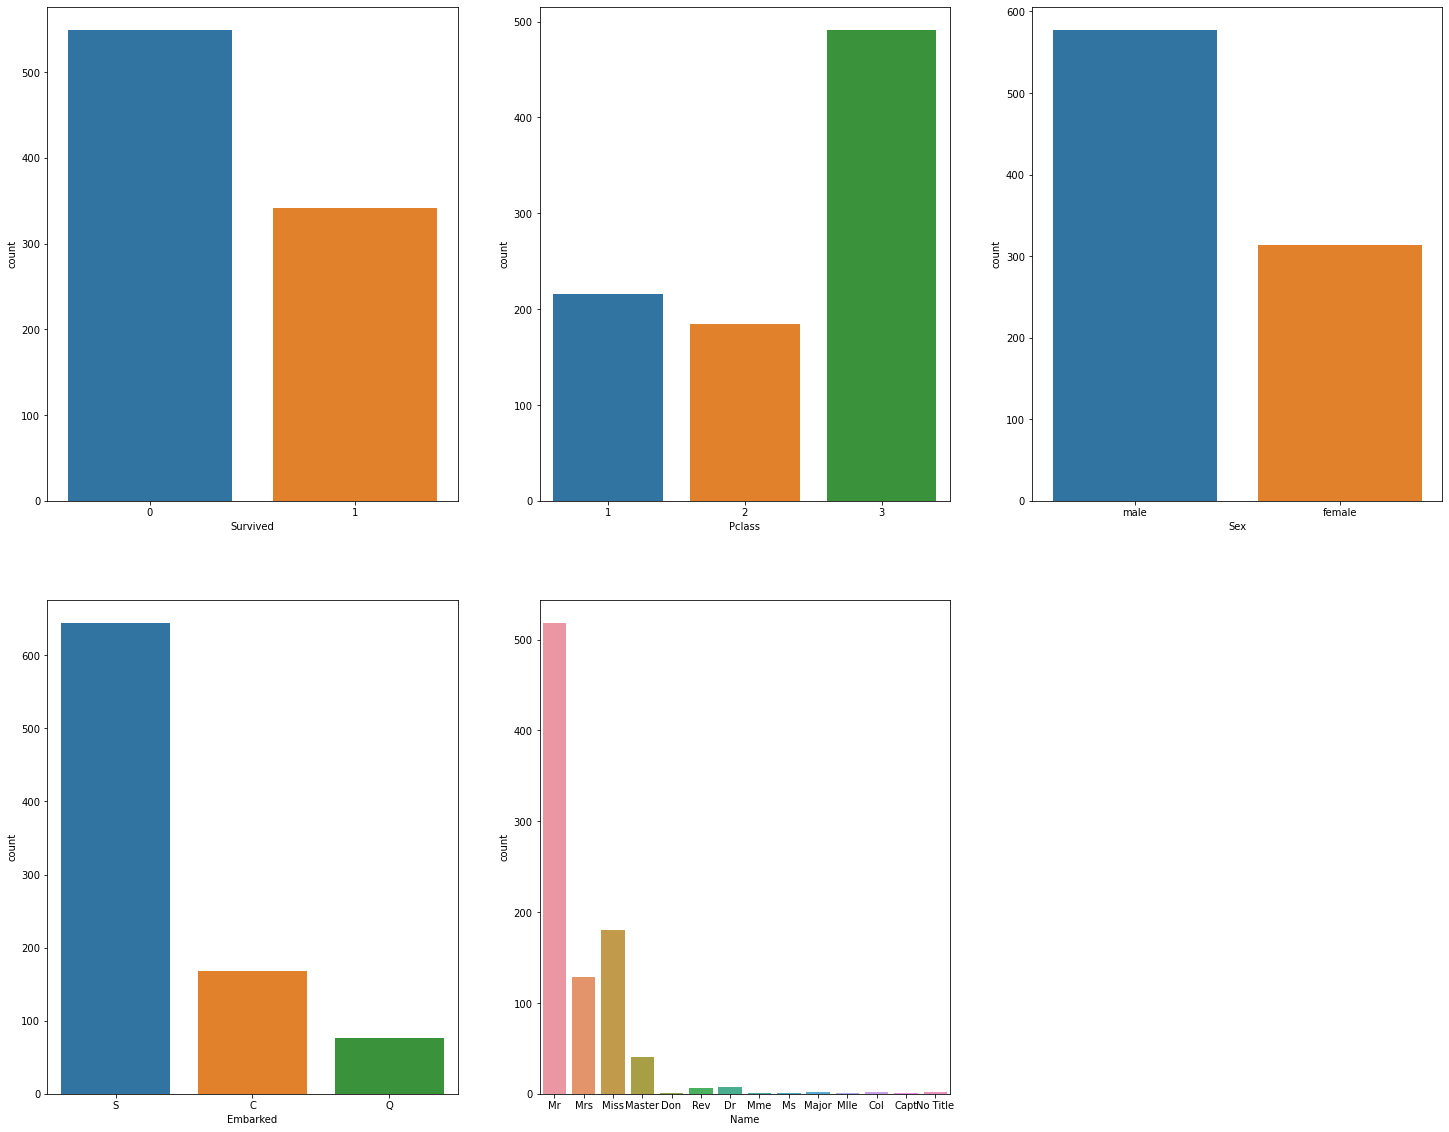

In [126]:
#We will see the distributions of the categorical features in the dataset
plt.figure(figsize = (25,20))
for n in enumerate(catFeature):
    plt.subplot(2,3, n[0]+1)
    sns.countplot(x=n[1], data = TrainDat)

From this we can take these conclusions:
1). More people died than survived.
2). 3rd class was the most numerous on the ship
3). There were more men than women on the ship
4). Most who embarked were from Southhampton
5). Most people had the title of 'Mr' (after our name transformation)

The same analysis will be done to see if there is a survival pattern for each categorical feature:

<Figure size 1800x1440 with 0 Axes>

<AxesSubplot:>

<AxesSubplot:xlabel='Survived', ylabel='count'>

<AxesSubplot:>

<AxesSubplot:xlabel='Pclass', ylabel='count'>

<AxesSubplot:>

<AxesSubplot:xlabel='Sex', ylabel='count'>

<AxesSubplot:>

<AxesSubplot:xlabel='Embarked', ylabel='count'>

<AxesSubplot:>

<AxesSubplot:xlabel='Name', ylabel='count'>

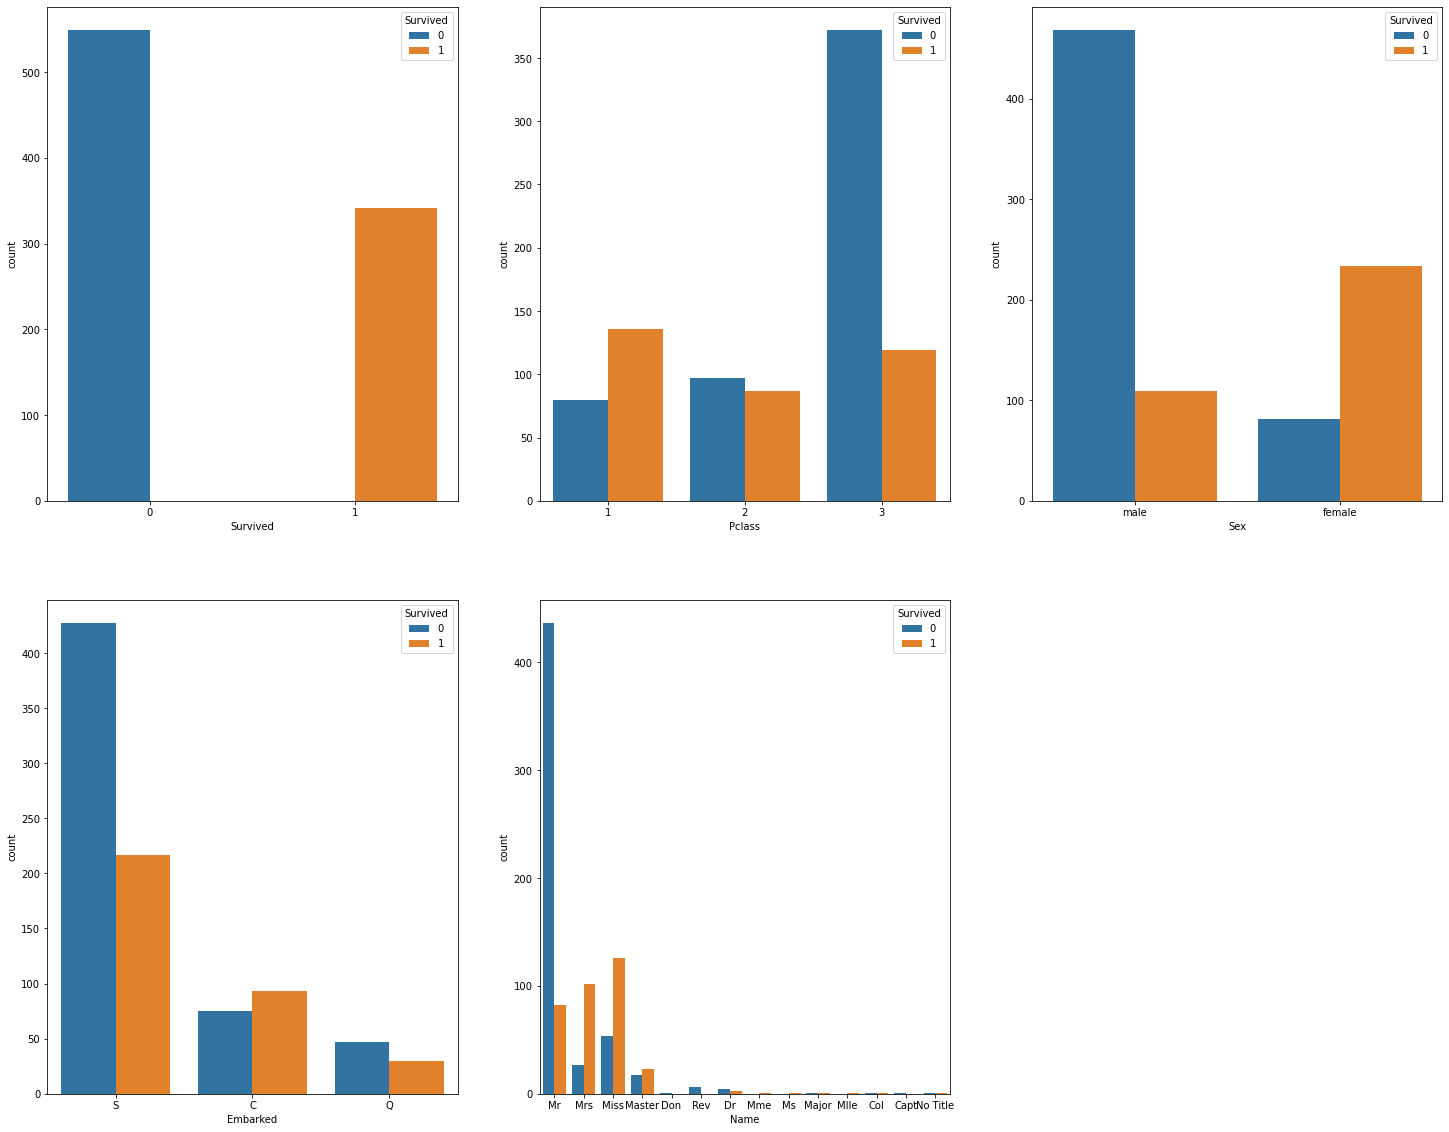

In [127]:
plt.figure(figsize = (25,20))
for n in enumerate(catFeature):
    plt.subplot(2,3, n[0]+1)
    sns.countplot(x=n[1], data = TrainDat, hue = 'Survived')

From this we can say a few things so far:
1). 1st class was the most likely to survive
2). Women were more likely to survive
3). If you embarked from Cherbourg you were more likely to survive
4). If you had the titles "Mrs, Miss, and Master" you were more likely to survive than die in the tragedy.

The graphs below will be scatter plots to see the numerical features and their relationships with survival:

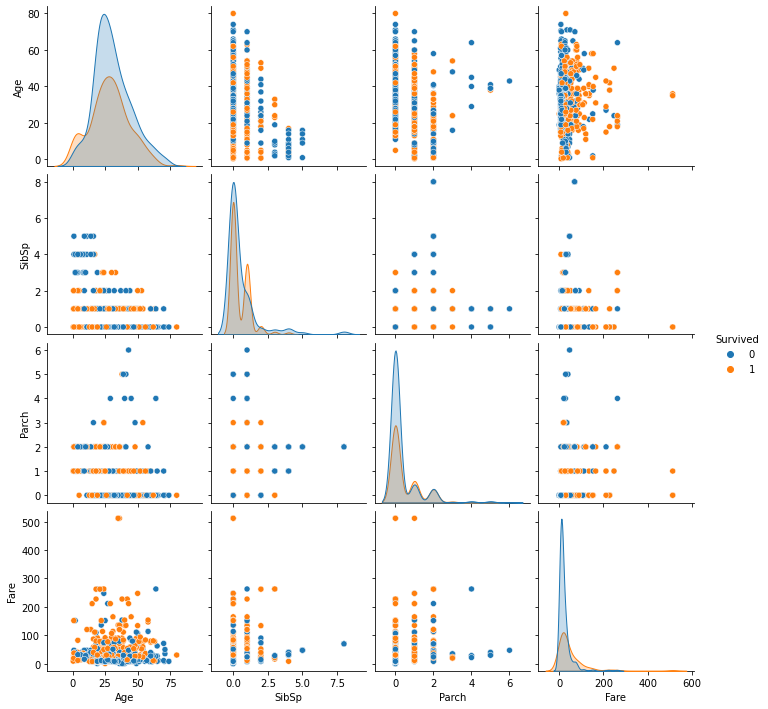

In [128]:
sns.pairplot(data = TrainDat.drop(columns = ['PassengerId','Pclass']), hue = 'Survived')

Admittedly, a lot of this is quite messy to see real correlations with, but even so, we can tell that the extreme ends of the Fare feature (>$300) had a high survival rate, and that most categories had more deaths than survivors.

In [129]:
TrainDat['Fare'].describe()


count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

We will now try with a correlation to survival to determine which of the numeric categories best correlate.

In [130]:
corrM1 = pd.DataFrame(TrainDat, columns = numFeature)
corrMat = corrM1.corrwith(TrainDat['Survived'])
corrMat

Age     -0.077221
SibSp   -0.035322
Parch    0.081629
Fare     0.257307
dtype: float64

From the numeric features we can see that there is not a good correlation between any of them and survival.  However, considering most of the passengers died across the board this is to be expected.  The best were using the absolute values of the correlation metrics would be the "Parch" column.

Data Processing

In [131]:
def clean_data(data):
    #Dropping columns that will not be necessary due to no new information given or lots of missing data
    data=data.drop(['PassengerId','Name','Ticket','Cabin'], axis = 1)
    
    #binning Age into different classes 'Children', 'Teenage', 'Adult', 'Elderly'
    data['Age'] = pd.cut(data['Age'], bins=[0,12,20,60,120], labels = ['Children','Teenage','Adult','Elder'])
    
    #Converting Fare into four categories 'Low, Median, Average, High'
    data['Fare'] = pd.cut(data['Fare'], bins=[0,7.91,14.45,31,120], labels = ['Low', 'Median','Average','High'])
    
    #OneHotEncoding all Categorical Columns
    data = pd.get_dummies(data, columns = ['Sex','Age','Embarked','Fare'])
    
    return data
    

In [132]:
TrainDat2 = TrainDat.copy()
TrainDat2 = clean_data(TrainDat2)

Model Creation

In [133]:
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.covariance import OAS
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

In [134]:
#First thing for all models is to create our training and testing data
X = TrainDat2.drop('Survived', axis = 1)
Y = TrainDat2['Survived']
xTrain, xTest, yTrain, yTest = train_test_split(X, Y,
                                               test_size = 0.3, random_state = 42)

In [135]:
#Need to import some more necessary libraries for k-fold and cross validation
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict

Model: Random Forest

RandomForestClassifier()

             Random Forest            
RF Accuracy is:  77.99
The RF cross validated score is:  81.82


<AxesSubplot:>

Text(0.5, 1, 'Confusion Matrix')

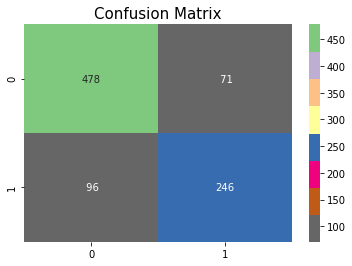

In [136]:
model = RandomForestClassifier()
model.fit(xTrain, yTrain)
predRF = model.predict(xTest)
print('             Random Forest            ')
print('RF Accuracy is: ', round(accuracy_score(predRF, yTest)*100,2))
#Now to Kfold the data into 10 equal sections
kfold = KFold(n_splits =8, shuffle = True, random_state =42)
#To cross validate and give a score
resRF = cross_val_score(model, X, Y, cv=10, scoring='accuracy')
print('The RF cross validated score is: ',round(resRF.mean()*100,2))
#Model Predictions
yPred = cross_val_predict(model,X, Y, cv=10)
#Create a Confusion Matrix
sns.heatmap(confusion_matrix(Y,yPred),annot=True, fmt='3.0f', cmap='Accent_r')
plt.title('Confusion Matrix', y=1, size=15)


Model: Gradient Boosted

GradientBoostingClassifier()

             Gradient Boosted            
Gradient Boosted Accuracy is:  77.99
The Gradient Boosted cross validated score is:  81.82


<AxesSubplot:>

Text(0.5, 1, 'Confusion Matrix')

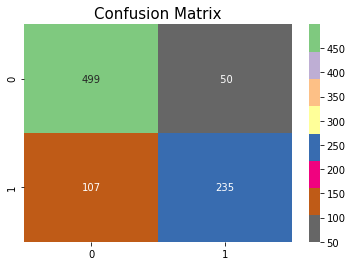

In [137]:
model = GradientBoostingClassifier()
model.fit(xTrain, yTrain)
predGrad = model.predict(xTest)
print('             Gradient Boosted            ')
print('Gradient Boosted Accuracy is: ', round(accuracy_score(predRF, yTest)*100,2))
#Now to Kfold the data into 10 equal sections
kfold = KFold(n_splits =8, shuffle = True, random_state =42)
#To cross validate and give a score
resGrad = cross_val_score(model, X, Y, cv=10, scoring='accuracy')
print('The Gradient Boosted cross validated score is: ',round(resRF.mean()*100,2))
#Model Predictions
yPred = cross_val_predict(model,X, Y, cv=10)
#Create a Confusion Matrix
sns.heatmap(confusion_matrix(Y,yPred),annot=True, fmt='3.0f', cmap='Accent_r')
plt.title('Confusion Matrix', y=1, size=15)

Model Evaluation

In [138]:
models = pd.DataFrame ({
    'Model':['RF','Gradient Boosted'],
    'Score':[resRF.mean(), resGrad.mean()]
})
models.sort_values(by = 'Score', ascending = False)

,Model,Score
1,Gradient Boosted,0.823795
0,RF,0.818190


HyperParameter Tuning

Hypertuning Random Forest Model

In [139]:
#We will generate random tunings and iterate to find the best version of these random tunings to determine our optimal hyperparameters
model = RandomForestClassifier()

#Number of trees in the forest
n_estimators = [200,300,400,500,600,700,800,900,1000,1100,1200,1300,1400,1500]
#Number of features to consider every split
max_features = ['auto','sqrt']
#Maximum number of levels in the tree
max_depth = [int(x) for x in np.linspace(10,110, num =11)]
max_depth.append(None)
#Minimum number of samples require to split a node
min_samples_split=[2,5,10]
#Minimum number of samples for training each tree
bootstrap = [True,False]


paramGrid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth':max_depth,
    'min_samples_split':min_samples_split,
    'bootstrap':bootstrap
}

randomRF = RandomizedSearchCV(estimator=model, param_distributions =paramGrid, n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)
#finding the best score with the best parameters
randomRF.fit(xTrain, yTrain)
print(randomRF.best_score_)
#best estimation
randomRF.best_estimator_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 300, 400, 500,
                                                         600, 700, 800, 900,
                                                         1000, 1100, 1200, 1300,
                                                         1400, 1500]},
                   random_state=42, verbose=2)

0.8218444196705067


RandomForestClassifier(max_depth=10, min_samples_split=10, n_estimators=300)

Hypertuning Gradient Boosting Model

In [140]:
#We will generate random tunings and iterate to find the best version of these random tunings to determine our optimal hyperparameters
model = GradientBoostingClassifier()

#Number of trees in the forest
n_estimators = [200,300,400,500,600,700,800,900,1000,1100,1200,1300,1400,1500]
#Number of features to consider every split
max_features = ['auto','sqrt']
#Maximum number of levels in the tree
max_depth = [int(x) for x in np.linspace(10,110, num =11)]
max_depth.append(None)
#Minimum number of samples require to split a node
min_samples_split=[2,5,10]
#Determine the Learning Rate of the model
learning_rate = [0.01,0.1,1,10,100]

paramGrid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth':max_depth,
    'min_samples_split':min_samples_split,
    'learning_rate':learning_rate
}

randomGrad = RandomizedSearchCV(estimator=model, param_distributions =paramGrid, n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)
#finding the best score with the best parameters
randomGrad.fit(xTrain, yTrain)
print(randomGrad.best_score_)
#best estimation
randomGrad.best_estimator_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=GradientBoostingClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.1, 1, 10,
                                                          100],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 300, 400, 500,
                                                         600, 700, 800, 900,
                                                         1000, 1100, 1200, 1300,
                                                         1400, 1500]},
                   random_state=42, verbose=2)

0.8138393410132542


GradientBoostingClassifier(learning_rate=0.01, max_depth=30,
                           max_features='sqrt', min_samples_split=10,
                           n_estimators=300)

Comparing our baseline and hyperparameter tuned models

In [141]:
#need to generate a prediction of data with the optimized parameters for our Random Forest Model
rfModel2 = RandomForestClassifier(max_depth = 10, max_features ='sqrt', min_samples_split=10, n_estimators=200)
rfModel2.fit(xTrain,yTrain)
predRF2 = rfModel2.predict(xTest)

#generating a prediction for our optimized parameters for our Gradient Boosting Model
gradModel2 = GradientBoostingClassifier(learning_rate=0.01, max_depth=30, max_features='sqrt', min_samples_split=10, n_estimators=300)
gradModel2.fit(xTrain,yTrain)
predGrad2 = gradModel2.predict(xTest)

print('RF Baseline Accuracy is: ', round(accuracy_score(predRF, yTest)*100,2))
print('RF Model 2 Accuracy is: ', round(accuracy_score(predRF2, yTest)*100,2))
print('Gradient Boosting Baseline Accuracy is: ', round(accuracy_score(predGrad, yTest)*100,2))
print('Gradient Boosting Model 2 Accuracy is: ', round(accuracy_score(predGrad2, yTest)*100,2))

RandomForestClassifier(max_depth=10, max_features='sqrt', min_samples_split=10,
                       n_estimators=200)

GradientBoostingClassifier(learning_rate=0.01, max_depth=30,
                           max_features='sqrt', min_samples_split=10,
                           n_estimators=300)

RF Baseline Accuracy is:  77.99
RF Model 2 Accuracy is:  79.85
Gradient Boosting Baseline Accuracy is:  82.09
Gradient Boosting Model 2 Accuracy is:  80.97


Applying the best parameters deterning in the Hyperparameter Tuning

In [142]:
rfModel = RandomForestClassifier(max_depth = 10, max_features ='sqrt', min_samples_split=10, n_estimators=200)
rfModel.fit(xTrain,yTrain)


RandomForestClassifier(max_depth=10, max_features='sqrt', min_samples_split=10,
                       n_estimators=200)

Test Data and Submission

In [143]:
#Cleaning the Test Data
testDat = clean_data(TestDat)

In [144]:
yPred = rfModel.predict(testDat)

In [145]:
submission = pd.DataFrame({
    "PassengerId":TestDat['PassengerId'],
    "Survived":yPred
})

In [146]:
submission.to_csv('Submission.csv', index = False)